#Problem Deffinition

Dalam sektor pertanian, memaksimalkan hasil panen (crop yield) merupakan faktor kunci untuk meningkatkan ketahanan pangan dan efisiensi produksi. Namun, hasil panen sangat dipengaruhi oleh berbagai faktor seperti kondisi geografis, iklim, jenis tanah, serta praktik pengelolaan lahan.

Seiring ketersediaan data yang semakin melimpah, pendekatan berbasis data (data-driven approach) dapat dimanfaatkan untuk memprediksi hasil panen secara lebih akurat, sehingga membantu petani dan pembuat kebijakan dalam pengambilan keputusan.

Tujuan dari proyek ini adalah untuk **membangun model prediksi machine learning yang mampu memperkirakan yield dari sebuah lahan pertanian.**

#Data Dictionary

Data dictionary
1. **Geographic features**

* **Field_ID**: A unique identifier for each field (BigInt).
* **Elevation**: The elevation of the field above sea level in metres (Float).
* **Latitude**: Geographical latitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)
* **Longitude**: Geographical longitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)
* **Location**: Province the field is in (Text).
* **Slope**: The slope of the land in the field (Float).

  
2. **Weather features**

* **Rainfall**: Amount of rainfall in the area in mm (Float).
* **Min_temperature_C**: Average minimum temperature recorded in Celsius (Float).(DUMMY VARIABLE)
* **Max_temperature_C**: Average maximum temperature recorded in Celsius (Float).(DUMMY VARIABLE)
* **Ave_temps**: Average temperature in Celcius (Float).


3. **Soil and crop features**

* **Soil_fertility**: A measure of soil fertility where 0 is infertile soil, and 1 is very fertile soil (Float).
* **Soil_type**: Type of soil present in the field (Text).
* **pH**: pH level of the soil, which is a measure of how acidic/basic the soil is (Float).

4. **Farm management features**

* **Field_ID**: Corresponding field identifier (BigInt).
* **Pollution_level**: Level of pollution in the area where 0 is unpolluted and 1 is very polluted (Float).
* **Plot_size**: Size of the plot in the field (Ha) (Float). (DUMMY VARIABLE)
* **Chosen_crop**: Type of crop chosen for cultivation (Text).
* **Annual_yield**: Annual yield from the field (Float). This is the total output of the field. The field size and type of crop will affect the Annual Yield (DUMMY VARIABLE - Removed)


5. **Target variable**

* **Standard_yield**: Standardised yield expected from the field, normalised per crop (Float). This is independent of field size, or crop type. Multiplying this number by the field size, and average crop yield will give the Annual_Yield.

#Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.graphics.correlation as sgc
from statsmodels.graphics.gofplots import qqplot
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
import sys
# Add the folder containing your module to the Python path
sys.path.append('/content/drive/MyDrive/agricultural yield')

ETL Process

In [4]:
import re
import numpy as np
import pandas as pd
from field_data_processor import FieldDataProcessor
# from weather_data_processor import WeatherDataProcessor
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

config_params = {
    "sql_query": """
            SELECT *
            FROM geographic_features
            LEFT JOIN weather_features USING (Field_ID)
            LEFT JOIN soil_and_crop_features USING (Field_ID)
            LEFT JOIN farm_management_features USING (Field_ID)
            """,
    "db_path": 'sqlite:////content/drive/MyDrive/agricultural yield/Maji_Ndogo_farm_survey_small.db',
    "columns_to_rename": {'Annual_yield': 'Crop_type', 'Crop_type': 'Annual_yield'},
    "values_to_rename": {'cassaval': 'cassava', 'wheatn': 'wheat', 'teaa': 'tea'},
    "weather_csv_path": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_station_data.csv",
    "weather_mapping_csv": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_data_field_mapping.csv",
    "regex_patterns" : {
            'Rainfall': r'(\d+(\.\d+)?)\s?mm',
            'Temperature': r'(\d+(\.\d+)?)\s?C',
            'Pollution_level': r'=\s*(-?\d+(\.\d+)?)|Pollution at \s*(-?\d+(\.\d+)?)'
            },
}
# Ignoring the field data for now.
field_processor = FieldDataProcessor(config_params)
field_processor.process()
field_df = field_processor.df

# We're not going to use the weather data this time, so we'll ignore it.
# weather_processor = WeatherDataProcessor(config_params)
# weather_processor.process()
# weather_df = weather_processor.weather_df

dataset = field_df.drop("Weather_station", axis=1)

2025-07-29 12:34:24,045 - field_data_processor.FieldDataProcessor - INFO - Sucessfully loaded data.
2025-07-29 12:34:24,052 - field_data_processor.FieldDataProcessor - INFO - Swapped columns: Annual_yield with Crop_type


In [5]:
dataset.to_csv('sampled_field_df.csv', index=False)

!pytest '/content/drive/MyDrive/agricultural yield/validate_data.py' -v

import os# Define the file paths
field_csv_path = 'sampled_field_df.csv'

# Delete sampled_field_df.csv if it exists
if os.path.exists(field_csv_path):
    os.remove(field_csv_path)
    print(f"Deleted {field_csv_path}")
else:
    print(f"{field_csv_path} does not exist.")

============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.4.1, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content
plugins: anyio-4.9.0, typeguard-4.4.4, langsmith-0.4.8
collected 4 items                                                              

drive/MyDrive/agricultural yield/validate_data.py::test_read_field_dataframe_shape PASSED [ 25%]
drive/MyDrive/agricultural yield/validate_data.py::test_field_dataframe_columns PASSED [ 50%]
drive/MyDrive/agricultural yield/validate_data.py::test_field_dataframe_non_negative_elevation PASSED [ 75%]
drive/MyDrive/agricultural yield/validate_data.py::test_crop_types_are_valid PASSED [100%]

============================== 4 passed in 1.74s ===============================
Deleted sampled_field_df.csv


#Exploratory Data Anlysis

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Field_ID           5654 non-null   int64  
 1   Elevation          5654 non-null   float64
 2   Latitude           5654 non-null   float64
 3   Longitude          5654 non-null   float64
 4   Location           5654 non-null   object 
 5   Slope              5654 non-null   float64
 6   Rainfall           5654 non-null   float64
 7   Min_temperature_C  5654 non-null   float64
 8   Max_temperature_C  5654 non-null   float64
 9   Ave_temps          5654 non-null   float64
 10  Soil_fertility     5654 non-null   float64
 11  Soil_type          5654 non-null   object 
 12  pH                 5654 non-null   float64
 13  Pollution_level    5654 non-null   float64
 14  Plot_size          5654 non-null   float64
 15  Annual_yield       5654 non-null   float64
 16  Crop_type          5654 

In [7]:
dataset.head()

,Field_ID,Elevation,Latitude,Longitude,Location,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,Soil_type,pH,Pollution_level,Plot_size,Annual_yield,Crop_type,Standard_yield
0,40734,786.05580,-7.389911,-7.556202,Rural_Akatsi,14.795113,1125.2,-3.1,33.1,15.00,0.62,Sandy,6.169393,0.085267,1.3,0.751354,cassava,0.577964
1,30629,674.33410,-7.736849,-1.051539,Rural_Sokoto,11.374611,1450.7,-3.9,30.6,13.35,0.64,Volcanic,5.676648,0.399684,2.2,1.069865,cassava,0.486302
2,39924,826.53390,-9.926616,0.115156,Rural_Sokoto,11.339692,2208.9,-1.8,28.4,13.30,0.69,Volcanic,5.331993,0.358029,3.4,2.208801,tea,0.649647
3,5754,574.94617,-2.420131,-6.592215,Rural_Kilimani,7.109855,328.8,-5.8,32.2,13.20,0.54,Loamy,5.328150,0.286687,2.4,1.277635,cassava,0.532348
4,14146,886.35300,-3.055434,-7.952609,Rural_Kilimani,55.007656,785.2,-2.5,31.0,14.25,0.72,Sandy,5.721234,0.043190,1.5,0.832614,wheat,0.555076


check Missing value

In [8]:
dataset.isnull().sum()

,0
Field_ID,0
Elevation,0
Latitude,0
Longitude,0
Location,0
Slope,0
Rainfall,0
Min_temperature_C,0
Max_temperature_C,0
Ave_temps,0


In [9]:
dataset.duplicated().sum()

np.int64(0)

Unique value

In [10]:
data_object = dataset[['Location', 'Soil_type', 'Crop_type']]

for feature in data_object:
  print(feature, ':', data_object[feature].nunique())

Location : 5
Soil_type : 6
Crop_type : 8


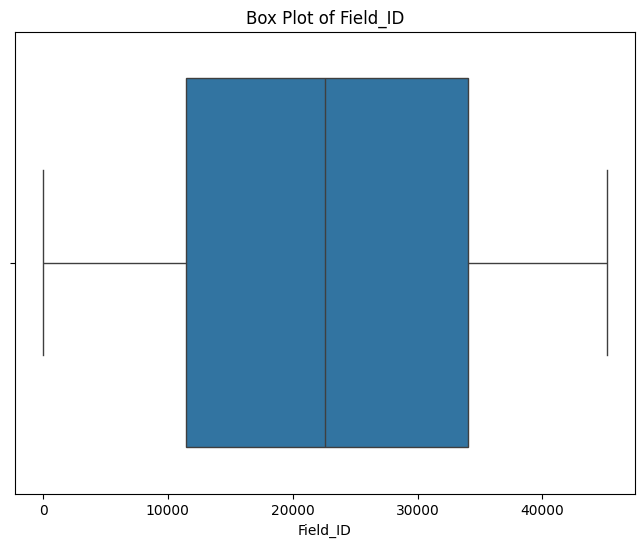

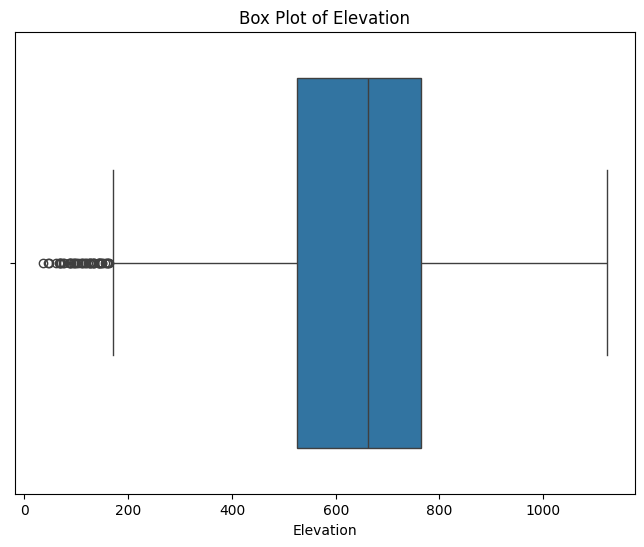

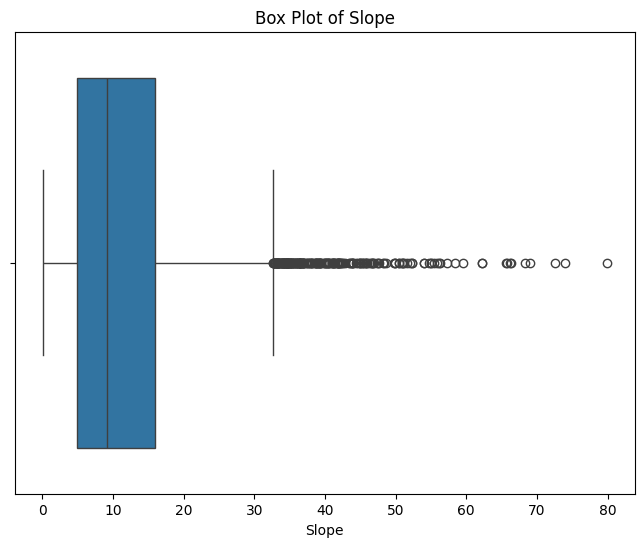

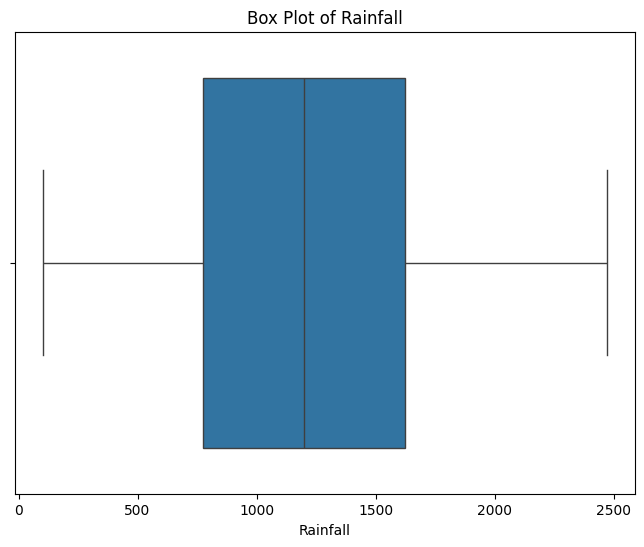

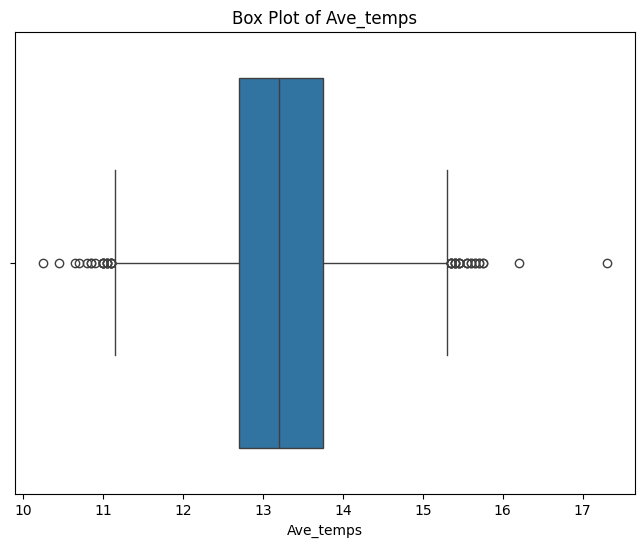

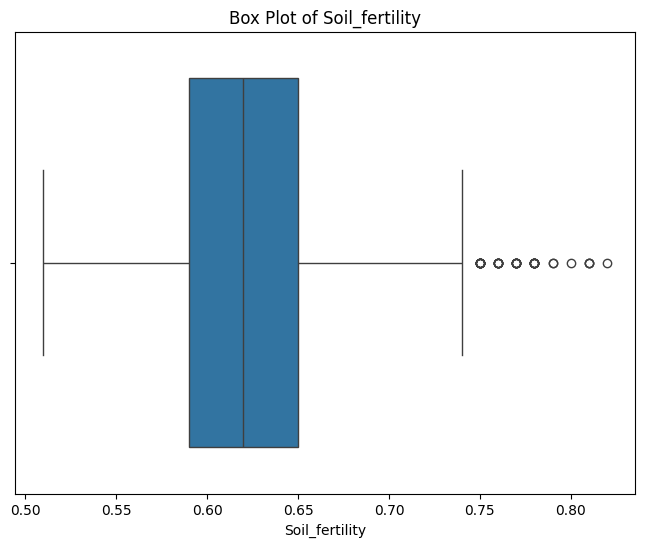

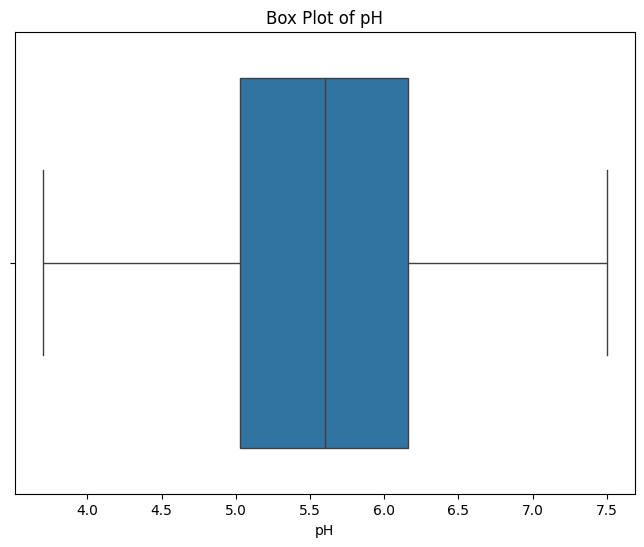

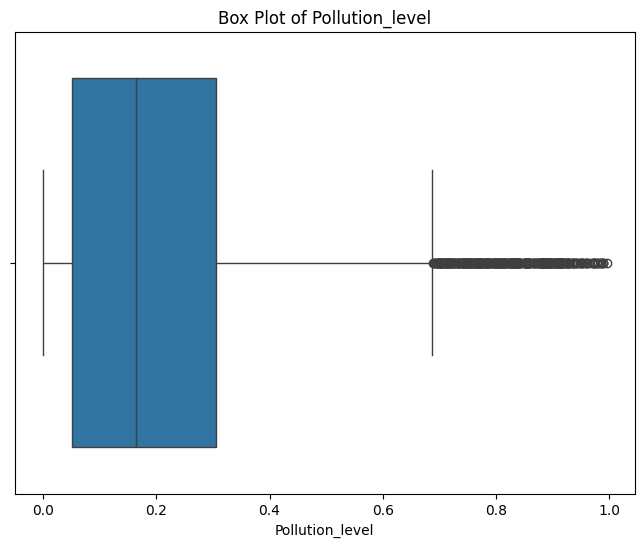

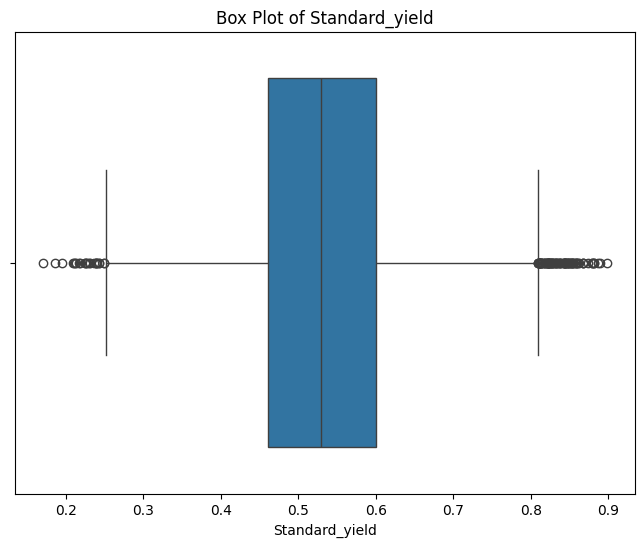

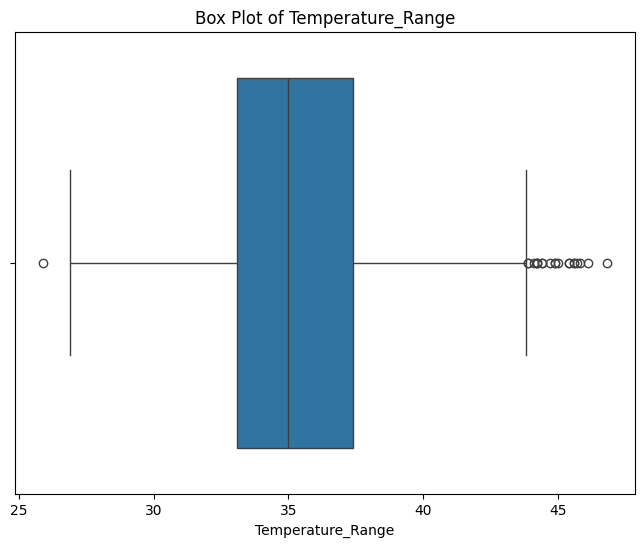

In [19]:
# Select only numerical columns from the dataset
numerical_features = dataset.select_dtypes(include=np.number).columns

# Create box plots for each numerical feature
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=dataset[feature])
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(feature)
    plt.show()

#Data preprocessing

##drop dummy data

In [11]:
to_drop = ['Latitude', 'Longitude', 'Annual_yield', 'Plot_size']
dataset = dataset.drop(columns=to_drop)

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Field_ID           5654 non-null   int64  
 1   Elevation          5654 non-null   float64
 2   Location           5654 non-null   object 
 3   Slope              5654 non-null   float64
 4   Rainfall           5654 non-null   float64
 5   Min_temperature_C  5654 non-null   float64
 6   Max_temperature_C  5654 non-null   float64
 7   Ave_temps          5654 non-null   float64
 8   Soil_fertility     5654 non-null   float64
 9   Soil_type          5654 non-null   object 
 10  pH                 5654 non-null   float64
 11  Pollution_level    5654 non-null   float64
 12  Crop_type          5654 non-null   object 
 13  Standard_yield     5654 non-null   float64
dtypes: float64(10), int64(1), object(3)
memory usage: 618.5+ KB


##feature engineering

Rather than including Min_temperature_C and Max_temperature_C separately — which could introduce multicollinearity and redundant information — do engineered a new feature called Temperature_Range to represent the daily fluctuation in temperature.

In [13]:
# Insert selected option here
dataset['Temperature_Range'] = dataset['Max_temperature_C'] - dataset['Min_temperature_C']
dataset = dataset.drop(columns=['Min_temperature_C', 'Max_temperature_C'])

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Field_ID           5654 non-null   int64  
 1   Elevation          5654 non-null   float64
 2   Location           5654 non-null   object 
 3   Slope              5654 non-null   float64
 4   Rainfall           5654 non-null   float64
 5   Ave_temps          5654 non-null   float64
 6   Soil_fertility     5654 non-null   float64
 7   Soil_type          5654 non-null   object 
 8   pH                 5654 non-null   float64
 9   Pollution_level    5654 non-null   float64
 10  Crop_type          5654 non-null   object 
 11  Standard_yield     5654 non-null   float64
 12  Temperature_Range  5654 non-null   float64
dtypes: float64(9), int64(1), object(3)
memory usage: 574.4+ KB


## one hot encoding

The categorical features in dataset need to be converted into a format suitable for modeling by applying dummy variable encoding to these categorical features.

In [14]:
import pandas as pd

# Create a copy of dataset
dataset_copy = dataset.copy()

# Separate the dependent variable
y = dataset_copy['Standard_yield']
X = dataset_copy.drop(columns=['Standard_yield', 'Field_ID'])

# Apply dummy variable encoding to the categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

X_encoded.shape[1]

24

In [16]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Elevation                5654 non-null   float64
 1   Slope                    5654 non-null   float64
 2   Rainfall                 5654 non-null   float64
 3   Ave_temps                5654 non-null   float64
 4   Soil_fertility           5654 non-null   float64
 5   pH                       5654 non-null   float64
 6   Pollution_level          5654 non-null   float64
 7   Temperature_Range        5654 non-null   float64
 8   Location_Rural_Amanzi    5654 non-null   bool   
 9   Location_Rural_Hawassa   5654 non-null   bool   
 10  Location_Rural_Kilimani  5654 non-null   bool   
 11  Location_Rural_Sokoto    5654 non-null   bool   
 12  Soil_type_Peaty          5654 non-null   bool   
 13  Soil_type_Rocky          5654 non-null   bool   
 14  Soil_type_Sandy         

In order to fit an ordinary least squares regression model to encoded data, it would need to make sure that all variables are numeric. Through dummy variable encoding, converted the categorical variables to multiple int/boolean variables (depending on the environment you are working on). The sm.OLS() method itself does not inherently handle boolean data types implicitly.

In [17]:
# Convert boolean columns to integer
X_encoded = X_encoded.astype(int)

X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Elevation                5654 non-null   int64
 1   Slope                    5654 non-null   int64
 2   Rainfall                 5654 non-null   int64
 3   Ave_temps                5654 non-null   int64
 4   Soil_fertility           5654 non-null   int64
 5   pH                       5654 non-null   int64
 6   Pollution_level          5654 non-null   int64
 7   Temperature_Range        5654 non-null   int64
 8   Location_Rural_Amanzi    5654 non-null   int64
 9   Location_Rural_Hawassa   5654 non-null   int64
 10  Location_Rural_Kilimani  5654 non-null   int64
 11  Location_Rural_Sokoto    5654 non-null   int64
 12  Soil_type_Peaty          5654 non-null   int64
 13  Soil_type_Rocky          5654 non-null   int64
 14  Soil_type_Sandy          5654 non-null   int64
 15  Soil

In [18]:
X_encoded.head()

,Elevation,Slope,Rainfall,Ave_temps,Soil_fertility,pH,Pollution_level,Temperature_Range,Location_Rural_Amanzi,Location_Rural_Hawassa,...,Soil_type_Sandy,Soil_type_Silt,Soil_type_Volcanic,Crop_type_cassava,Crop_type_coffee,Crop_type_maize,Crop_type_potato,Crop_type_rice,Crop_type_tea,Crop_type_wheat
0,786,14,1125,15,0,6,0,36,0,0,...,1,0,0,1,0,0,0,0,0,0
1,674,11,1450,13,0,5,0,34,0,0,...,0,0,1,1,0,0,0,0,0,0
2,826,11,2208,13,0,5,0,30,0,0,...,0,0,1,0,0,0,0,0,1,0
3,574,7,328,13,0,5,0,38,0,0,...,0,0,0,1,0,0,0,0,0,0
4,886,55,785,14,0,5,0,33,0,0,...,1,0,0,0,0,0,0,0,0,1


#Predict Model

##Baseline model

In [21]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4523, 24)
X_test shape: (1131, 24)
y_train shape: (4523,)
y_test shape: (1131,)


##Ridge regression

In [55]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [37]:
# Setup random seed
np.random.seed(24)

# Instantiate and fit the model on the training set
model_ridge = Ridge()
model_ridge.fit(X_train, y_train)

Ridge()

In [38]:
r2_train_ridge = model_ridge.score(X_train, y_train)
r2_test_ridge = model_ridge.score(X_test, y_test)

print("Train R²:", r2_train_ridge)
print("Test R² :", r2_test_ridge)

Train R²: 0.44967890361593854
Test R² : 0.4623802333177456


In [58]:
y_train_ridge = model_ridge.predict(X_train)
y_test_ridge = model_ridge.predict(X_test)

# Hitung MSE
mse_train_ridge = mean_squared_error(y_train, y_train_ridge)
mse_test_ridge = mean_squared_error(y_test, y_test_ridge)

print("Train MSE:", mse_train_ridge)
print("Test MSE :", mse_test_ridge)

Train MSE: 0.006758514402644711
Test MSE : 0.007164012523516111


##Lasso Regresion

In [39]:
# Import algorithm
from sklearn.linear_model import Lasso

# Setup random seed
np.random.seed(24)

# Instantiate and fit the model on the training set
model_lasso = Lasso()
model_lasso.fit(X_train, y_train)

Lasso()

In [40]:
r2_train_lasso = model_lasso.score(X_train, y_train)
r2_test_lasso = model_lasso.score(X_test, y_test)

print("Train R²:", r2_train_lasso)
print("Test R² :", r2_test_lasso)

Train R²: 0.015683327528520086
Test R² : 0.016893741041965615


In [59]:
y_train_lasso = model_lasso.predict(X_train)
y_test_lasso = model_lasso.predict(X_test)

# Hitung MSE
mse_train_lasso = mean_squared_error(y_train, y_train_lasso)
mse_test_lasso = mean_squared_error(y_test, y_test_lasso)

print("Train MSE:", mse_train_lasso)
print("Test MSE :", mse_test_lasso)

Train MSE: 0.012088430647803322
Test MSE : 0.013100309898547678


##Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

In [41]:
reg = RandomForestRegressor(n_jobs=-1)
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators, 'max_depth': maximumdepth}

model2 = RandomizedSearchCV(estimator=reg,
                            param_distributions=parameters,
                            cv=3,
                            n_iter=6,
                            scoring='r2',
                            random_state=42)

model2.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1), n_iter=6,
                   param_distributions={'max_depth': [1, 5, 7, 10, 15, 25, 30],
                                        'n_estimators': [5, 10, 50, 100, 120]},
                   random_state=42, scoring='r2')

In [32]:
model2.best_params_

{'n_estimators': 120, 'max_depth': 25}

In [43]:
model_rf = RandomForestRegressor(max_depth=25, n_estimators=120, random_state=42)
model_rf.fit(X_train, y_train)

In [44]:
r2_train_rf = model_rf.score(X_train, y_train)
r2_test_rf = model_rf.score(X_test, y_test)

print("Train R²:", r2_train_rf)
print("Test R² :", r2_test_rf)

Train R²: 0.9836492325423978
Test R² : 0.8954015382070221


In [60]:
y_train_rf = model_rf.predict(X_train)
y_test_rf = model_rf.predict(X_test)

# Hitung MSE
mse_train_rf = mean_squared_error(y_train, y_train_rf)
mse_test_rf = mean_squared_error(y_test, y_test_rf)

print("Train MSE:", mse_train_rf)
print("Test MSE :", mse_test_rf)

Train MSE: 0.0002008043996179599
Test MSE : 0.001393819083047769


##Decision tree

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [46]:
params = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

search_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), params, scoring='r2', cv=3)
search_dt.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2')

In [47]:
search_dt.best_params_

{'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}

In [48]:
model_dt = DecisionTreeRegressor(min_samples_leaf=4, min_samples_split=10, random_state=42)

# Training
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(min_samples_leaf=4, min_samples_split=10, random_state=42)

In [49]:
r2_train_dt = model_dt.score(X_train, y_train)
r2_test_dt = model_dt.score(X_test, y_test)

print("Train R²:", r2_train_dt)
print("Test R² :", r2_test_dt)

Train R²: 0.9444050312757911
Test R² : 0.8470624425288935


In [61]:
y_train_dt = model_dt.predict(X_train)
y_test_dt = model_dt.predict(X_test)

# Hitung MSE
mse_train_dt = mean_squared_error(y_train, y_train_dt)
mse_test_dt = mean_squared_error(y_test, y_test_dt)

print("Train MSE:", mse_train_dt)
print("Test MSE :", mse_test_dt)

Train MSE: 0.0006827639341940193
Test MSE : 0.0020379581349852494


##XGBoost

In [50]:
from xgboost import XGBRegressor

In [51]:
# Model dasar
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Randomized search
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='r2',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit model ke data
xgb_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='r2', verbose=1)

In [52]:
xgb_search.best_params_

{'subsample': 1.0,
 'reg_lambda': 1.5,
 'reg_alpha': 0,
 'n_estimators': 300,
 'max_depth': 5,
 'learning_rate': 0.1,
 'colsample_bytree': 1.0}

In [53]:
model_xgb = XGBRegressor(subsample=1, reg_lambda=1.5, reg_alpha=0, n_estimators=300, max_depth=5,
                         learning_rate=0.1, random_state=42)

model_xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [54]:
r2_train_xgb = model_xgb.score(X_train, y_train)
r2_test_xgb = model_xgb.score(X_test, y_test)

print("Train R²:", r2_train_xgb)
print("Test R² :", r2_test_xgb)

Train R²: 0.952310189633221
Test R² : 0.9077453649521217


In [62]:
y_train_xgb = model_xgb.predict(X_train)
y_test_xgb = model_xgb.predict(X_test)

# Hitung MSE
mse_train_xgb = mean_squared_error(y_train, y_train_xgb)
mse_test_xgb = mean_squared_error(y_test, y_test_xgb)

print("Train MSE:", mse_train_xgb)
print("Test MSE :", mse_test_xgb)

Train MSE: 0.000585680382491341
Test MSE : 0.0012293323307549136


#Feature importance

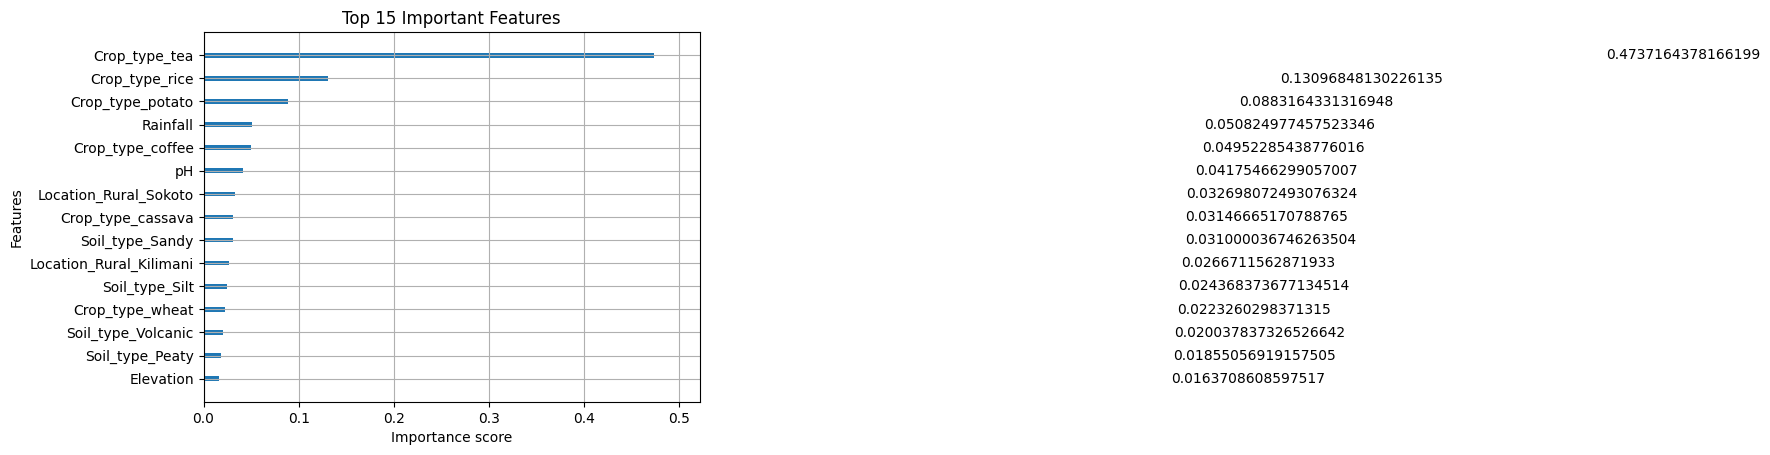

In [63]:
from xgboost import plot_importance

# Jika ini model terbaik kamu:
plot_importance(model_xgb, max_num_features=15, importance_type='gain')
plt.title("Top 15 Important Features")
plt.show()